# Models
In this notebook we will generate several different models using the already engineered features. We will then evaluate the models using cross validation and select the best model to use for our predictions.

In [68]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [69]:
GEO = 'texas_florida'
df = pd.read_csv(f'../../data/processed/features_{GEO}.csv')
df.index = df["review_id"]
df.drop(columns=["review_id"], inplace=True)

print(df.shape)
df.head()

(1629, 101)


,tsne2_comments_2D_0,tsne2_comments_2D_1,tsne3_comments_3D_0,tsne3_comments_3D_1,tsne3_comments_3D_2,tsne2_description_2D_0,tsne2_description_2D_1,tsne3_description_3D_0,tsne3_description_3D_1,tsne3_description_3D_2,...,amenityall_dishwasher,amenityall_silverware,amenityall_bathtub,amenityall_lockbox,amenityall_crib,amenityall_elevator,amenityall_gym,amenityall_oven,amenityall_toilet,label
review_id,,,,,,,,,,,,,,,,,,,,,
83097,36.76,-100.08,7.22,-41.55,2.67,36.76,-100.08,7.22,-41.55,2.67,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
133337,36.76,-100.08,10.17,-41.86,-2.04,36.76,-100.08,10.17,-41.86,-2.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
150928,32.36,-99.52,11.88,-44.53,2.47,32.36,-99.52,11.88,-44.53,2.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
2706775,32.36,-99.52,11.88,-44.53,2.47,32.36,-99.52,11.88,-44.53,2.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good
8602878,32.36,-99.52,11.88,-44.53,2.47,32.36,-99.52,11.88,-44.53,2.47,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,good


In [70]:
df.label.value_counts()

good     1320
mbad      118
mgood     105
bad        84
Name: label, dtype: int64

Drop NA labels... THANKS Charlie :/

In [71]:
df = df.dropna()

The data is extremely imbalanced. We can use the `imbalanced-learn` Python library, which has several implementations of resampling methods to deal with this problem. We will use the `SMOTE` method, which oversamples the minority class.

In [72]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(df.drop(columns=["label"]), df["label"])

print("Balanced labels:")
y.value_counts()

Balanced labels:


good     1320
mgood    1320
mbad     1320
bad      1320
Name: label, dtype: int64

## Testing out different feature combinations
We want to try the different combinations of features to see which ones work best.

In [79]:
import itertools

feature_sets = [
    "tsne2_comments_2D_",
    "tsne3_comments_3D_",
    "tsne2_description_2D_",
    "tsne3_description_3D_",
    "3gram09_",
    "3gram10_",
    "amenity005_",
    "amenityall_"
]

# get all combinations of feature sets of all lengths
feature_sets_combinations = []
for i in range(1, len(feature_sets) + 1):
    feature_sets_combinations += [list(x) for x in itertools.combinations(feature_sets, i)]

print(f"Number of feature sets combinations: {len(feature_sets_combinations)}")

Number of feature sets combinations: 255


In [80]:
from lazypredict.Supervised import LazyClassifier

top_models = {}
best_model = None
best_accuracy = -1
best_feature_set = None

num_of_feature_sets_combinations = len(feature_sets_combinations)

for i, feature_sets_combination in enumerate(feature_sets_combinations):

    print(f"Testing feature sets combination {i + 1} of {num_of_feature_sets_combinations} ({feature_sets_combination})")

    # get column subset
    df_subset_columns = [c for c in df.columns if any([c.startswith(f) for f in feature_sets_combination])]
    df_subset_columns.append("label")

    # oversample and get train/test split
    df_subset = df[df_subset_columns]
    X, y = oversample.fit_resample(df_subset.drop(columns=["label"]), df_subset["label"])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train model
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    top_models_for_subset = models.sort_values(by="Accuracy", ascending=False).head(10)

    top_model = models.iloc[0]
    accuracy = top_model["Accuracy"]
    name = top_model.name
    print(f"Top model for {feature_sets_combination}: {name}. Accuracy = {accuracy}")
    if top_model["Accuracy"] > best_accuracy:
        best_accuracy = top_model["Accuracy"]
        best_model = top_model
        best_feature_set = feature_sets_combination
        print(f"New best model found! Accuracy = {accuracy}")

    # save results
    top_models[",".join(feature_sets_combination)] = top_models_for_subset

    print()


print(f"Best model: {best_model.name} with feature set {best_feature_set}\nAccuracy = {best_accuracy}")

import pickle
# save top_models
with open(f"../../data/processed/top_models_{GEO}.pickle", "wb") as f:
    pickle.dump(top_models, f)

Testing feature sets combination 1 of 255 (['tsne2_comments_2D_'])


100%|██████████| 29/29 [00:05<00:00,  5.50it/s]


Top model for ['tsne2_comments_2D_']: ExtraTreesClassifier. Accuracy = 0.696969696969697
New best model found! Accuracy = 0.696969696969697

Testing feature sets combination 2 of 255 (['tsne3_comments_3D_'])


100%|██████████| 29/29 [00:05<00:00,  5.50it/s]


Top model for ['tsne3_comments_3D_']: ExtraTreesClassifier. Accuracy = 0.7973484848484849
New best model found! Accuracy = 0.7973484848484849

Testing feature sets combination 3 of 255 (['tsne2_description_2D_'])


100%|██████████| 29/29 [00:05<00:00,  5.33it/s]


Top model for ['tsne2_description_2D_']: ExtraTreesClassifier. Accuracy = 0.7083333333333334

Testing feature sets combination 4 of 255 (['tsne3_description_3D_'])


100%|██████████| 29/29 [00:05<00:00,  5.73it/s]


Top model for ['tsne3_description_3D_']: ExtraTreesClassifier. Accuracy = 0.7897727272727273

Testing feature sets combination 5 of 255 (['3gram09_'])


100%|██████████| 29/29 [00:10<00:00,  2.68it/s]


Top model for ['3gram09_']: NearestCentroid. Accuracy = 0.2774621212121212

Testing feature sets combination 6 of 255 (['3gram10_'])


100%|██████████| 29/29 [00:04<00:00,  6.06it/s]


Top model for ['3gram10_']: QuadraticDiscriminantAnalysis. Accuracy = 0.2793560606060606

Testing feature sets combination 7 of 255 (['amenity005_'])


100%|██████████| 29/29 [00:07<00:00,  3.68it/s]


Top model for ['amenity005_']: RandomForestClassifier. Accuracy = 0.3390151515151515

Testing feature sets combination 8 of 255 (['amenityall_'])


100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


Top model for ['amenityall_']: ExtraTreesClassifier. Accuracy = 0.4696969696969697

Testing feature sets combination 9 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_'])


100%|██████████| 29/29 [00:06<00:00,  4.82it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_']: ExtraTreesClassifier. Accuracy = 0.7926136363636364

Testing feature sets combination 10 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_'])


100%|██████████| 29/29 [00:06<00:00,  4.61it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_']: RandomForestClassifier. Accuracy = 0.6960227272727273

Testing feature sets combination 11 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_'])


100%|██████████| 29/29 [00:06<00:00,  4.80it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_']: ExtraTreesClassifier. Accuracy = 0.8001893939393939
New best model found! Accuracy = 0.8001893939393939

Testing feature sets combination 12 of 255 (['tsne2_comments_2D_', '3gram09_'])


100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Top model for ['tsne2_comments_2D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.7064393939393939

Testing feature sets combination 13 of 255 (['tsne2_comments_2D_', '3gram10_'])


100%|██████████| 29/29 [00:06<00:00,  4.15it/s]


Top model for ['tsne2_comments_2D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7102272727272727

Testing feature sets combination 14 of 255 (['tsne2_comments_2D_', 'amenity005_'])


100%|██████████| 29/29 [00:08<00:00,  3.29it/s]


Top model for ['tsne2_comments_2D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8674242424242424
New best model found! Accuracy = 0.8674242424242424

Testing feature sets combination 15 of 255 (['tsne2_comments_2D_', 'amenityall_'])


100%|██████████| 29/29 [00:11<00:00,  2.56it/s]


Top model for ['tsne2_comments_2D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8797348484848485
New best model found! Accuracy = 0.8797348484848485

Testing feature sets combination 16 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_'])


100%|██████████| 29/29 [00:06<00:00,  4.71it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_']: ExtraTreesClassifier. Accuracy = 0.8068181818181818

Testing feature sets combination 17 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_'])


100%|██████████| 29/29 [00:06<00:00,  4.41it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_']: ExtraTreesClassifier. Accuracy = 0.7964015151515151

Testing feature sets combination 18 of 255 (['tsne3_comments_3D_', '3gram09_'])


100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


Top model for ['tsne3_comments_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.7926136363636364

Testing feature sets combination 19 of 255 (['tsne3_comments_3D_', '3gram10_'])


100%|██████████| 29/29 [00:07<00:00,  3.90it/s]


Top model for ['tsne3_comments_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7935606060606061

Testing feature sets combination 20 of 255 (['tsne3_comments_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:08<00:00,  3.26it/s]


Top model for ['tsne3_comments_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8901515151515151
New best model found! Accuracy = 0.8901515151515151

Testing feature sets combination 21 of 255 (['tsne3_comments_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


Top model for ['tsne3_comments_3D_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.9147727272727273
New best model found! Accuracy = 0.9147727272727273

Testing feature sets combination 22 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_'])


100%|██████████| 29/29 [00:06<00:00,  4.62it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_']: ExtraTreesClassifier. Accuracy = 0.7888257575757576

Testing feature sets combination 23 of 255 (['tsne2_description_2D_', '3gram09_'])


100%|██████████| 29/29 [00:12<00:00,  2.28it/s]


Top model for ['tsne2_description_2D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.7073863636363636

Testing feature sets combination 24 of 255 (['tsne2_description_2D_', '3gram10_'])


100%|██████████| 29/29 [00:08<00:00,  3.59it/s]


Top model for ['tsne2_description_2D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7178030303030303

Testing feature sets combination 25 of 255 (['tsne2_description_2D_', 'amenity005_'])


100%|██████████| 29/29 [00:09<00:00,  3.15it/s]


Top model for ['tsne2_description_2D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8560606060606061

Testing feature sets combination 26 of 255 (['tsne2_description_2D_', 'amenityall_'])


100%|██████████| 29/29 [00:12<00:00,  2.42it/s]


Top model for ['tsne2_description_2D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.875

Testing feature sets combination 27 of 255 (['tsne3_description_3D_', '3gram09_'])


100%|██████████| 29/29 [00:13<00:00,  2.14it/s]


Top model for ['tsne3_description_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.7888257575757576

Testing feature sets combination 28 of 255 (['tsne3_description_3D_', '3gram10_'])


100%|██████████| 29/29 [00:07<00:00,  3.77it/s]


Top model for ['tsne3_description_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.790719696969697

Testing feature sets combination 29 of 255 (['tsne3_description_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:09<00:00,  3.09it/s]


Top model for ['tsne3_description_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8825757575757576

Testing feature sets combination 30 of 255 (['tsne3_description_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:12<00:00,  2.24it/s]


Top model for ['tsne3_description_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9232954545454546
New best model found! Accuracy = 0.9232954545454546

Testing feature sets combination 31 of 255 (['3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:13<00:00,  2.15it/s]


Top model for ['3gram09_', '3gram10_']: QuadraticDiscriminantAnalysis. Accuracy = 0.2803030303030303

Testing feature sets combination 32 of 255 (['3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:16<00:00,  1.71it/s]


Top model for ['3gram09_', 'amenity005_']: RandomForestClassifier. Accuracy = 0.3683712121212121

Testing feature sets combination 33 of 255 (['3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Top model for ['3gram09_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.5179924242424242

Testing feature sets combination 34 of 255 (['3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:09<00:00,  3.16it/s]


Top model for ['3gram10_', 'amenity005_']: BaggingClassifier. Accuracy = 0.36363636363636365

Testing feature sets combination 35 of 255 (['3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:13<00:00,  2.23it/s]


Top model for ['3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.47632575757575757

Testing feature sets combination 36 of 255 (['amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Top model for ['amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.48011363636363635

Testing feature sets combination 37 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_'])


100%|██████████| 29/29 [00:08<00:00,  3.41it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_']: ExtraTreesClassifier. Accuracy = 0.7982954545454546

Testing feature sets combination 38 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_'])


100%|██████████| 29/29 [00:08<00:00,  3.31it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_']: ExtraTreesClassifier. Accuracy = 0.790719696969697

Testing feature sets combination 39 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_'])


100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.8134469696969697

Testing feature sets combination 40 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram10_'])


100%|██████████| 29/29 [00:09<00:00,  3.07it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7935606060606061

Testing feature sets combination 41 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.55it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8929924242424242

Testing feature sets combination 42 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.90it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9147727272727273

Testing feature sets combination 43 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_'])


100%|██████████| 29/29 [00:08<00:00,  3.30it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_']: ExtraTreesClassifier. Accuracy = 0.78125

Testing feature sets combination 44 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_'])


100%|██████████| 29/29 [00:18<00:00,  1.57it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.6846590909090909

Testing feature sets combination 45 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram10_'])


100%|██████████| 29/29 [00:11<00:00,  2.59it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7263257575757576

Testing feature sets combination 46 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'amenity005_'])


100%|██████████| 29/29 [00:13<00:00,  2.09it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8494318181818182

Testing feature sets combination 47 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.57it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8958333333333334

Testing feature sets combination 48 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_'])


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.803030303030303

Testing feature sets combination 49 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram10_'])


100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8039772727272727

Testing feature sets combination 50 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8958333333333334

Testing feature sets combination 51 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.82it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9090909090909091

Testing feature sets combination 52 of 255 (['tsne2_comments_2D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:14<00:00,  1.94it/s]


Top model for ['tsne2_comments_2D_', '3gram09_', '3gram10_']: RandomForestClassifier. Accuracy = 0.7121212121212122

Testing feature sets combination 53 of 255 (['tsne2_comments_2D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:19<00:00,  1.48it/s]


Top model for ['tsne2_comments_2D_', '3gram09_', 'amenity005_']: RandomForestClassifier. Accuracy = 0.8371212121212122

Testing feature sets combination 54 of 255 (['tsne2_comments_2D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.34it/s]


Top model for ['tsne2_comments_2D_', '3gram09_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8854166666666666

Testing feature sets combination 55 of 255 (['tsne2_comments_2D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:10<00:00,  2.77it/s]


Top model for ['tsne2_comments_2D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8465909090909091

Testing feature sets combination 56 of 255 (['tsne2_comments_2D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


Top model for ['tsne2_comments_2D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8759469696969697

Testing feature sets combination 57 of 255 (['tsne2_comments_2D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.63it/s]


Top model for ['tsne2_comments_2D_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8787878787878788

Testing feature sets combination 58 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_'])


100%|██████████| 29/29 [00:08<00:00,  3.45it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_']: ExtraTreesClassifier. Accuracy = 0.7954545454545454

Testing feature sets combination 59 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_'])


100%|██████████| 29/29 [00:15<00:00,  1.85it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.8020833333333334

Testing feature sets combination 60 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_'])


100%|██████████| 29/29 [00:08<00:00,  3.31it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8001893939393939

Testing feature sets combination 61 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.62it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8854166666666666

Testing feature sets combination 62 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.90it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9176136363636364

Testing feature sets combination 63 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_'])


100%|██████████| 29/29 [00:16<00:00,  1.71it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_']: RandomForestClassifier. Accuracy = 0.8011363636363636

Testing feature sets combination 64 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_'])


100%|██████████| 29/29 [00:09<00:00,  2.96it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7982954545454546

Testing feature sets combination 65 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.46it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9043560606060606

Testing feature sets combination 66 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.83it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9204545454545454

Testing feature sets combination 67 of 255 (['tsne3_comments_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:15<00:00,  1.86it/s]


Top model for ['tsne3_comments_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7897727272727273

Testing feature sets combination 68 of 255 (['tsne3_comments_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:20<00:00,  1.45it/s]


Top model for ['tsne3_comments_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.896780303030303

Testing feature sets combination 69 of 255 (['tsne3_comments_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.26it/s]


Top model for ['tsne3_comments_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9081439393939394

Testing feature sets combination 70 of 255 (['tsne3_comments_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.59it/s]


Top model for ['tsne3_comments_3D_', '3gram10_', 'amenity005_']: RandomForestClassifier. Accuracy = 0.8816287878787878

Testing feature sets combination 71 of 255 (['tsne3_comments_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  2.00it/s]


Top model for ['tsne3_comments_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9147727272727273

Testing feature sets combination 72 of 255 (['tsne3_comments_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.63it/s]


Top model for ['tsne3_comments_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9128787878787878

Testing feature sets combination 73 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_'])


100%|██████████| 29/29 [00:16<00:00,  1.81it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.7926136363636364

Testing feature sets combination 74 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_'])


100%|██████████| 29/29 [00:09<00:00,  3.13it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8058712121212122

Testing feature sets combination 75 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.55it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8854166666666666

Testing feature sets combination 76 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.88it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9128787878787878

Testing feature sets combination 77 of 255 (['tsne2_description_2D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Top model for ['tsne2_description_2D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.6931818181818182

Testing feature sets combination 78 of 255 (['tsne2_description_2D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:20<00:00,  1.44it/s]


Top model for ['tsne2_description_2D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8418560606060606

Testing feature sets combination 79 of 255 (['tsne2_description_2D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.23it/s]


Top model for ['tsne2_description_2D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8797348484848485

Testing feature sets combination 80 of 255 (['tsne2_description_2D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:10<00:00,  2.67it/s]


Top model for ['tsne2_description_2D_', '3gram10_', 'amenity005_']: RandomForestClassifier. Accuracy = 0.8390151515151515

Testing feature sets combination 81 of 255 (['tsne2_description_2D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  2.04it/s]


Top model for ['tsne2_description_2D_', '3gram10_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.8683712121212122

Testing feature sets combination 82 of 255 (['tsne2_description_2D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.66it/s]


Top model for ['tsne2_description_2D_', 'amenity005_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.8683712121212122

Testing feature sets combination 83 of 255 (['tsne3_description_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:15<00:00,  1.88it/s]


Top model for ['tsne3_description_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7840909090909091

Testing feature sets combination 84 of 255 (['tsne3_description_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:20<00:00,  1.45it/s]


Top model for ['tsne3_description_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8920454545454546

Testing feature sets combination 85 of 255 (['tsne3_description_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


Top model for ['tsne3_description_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9270833333333334
New best model found! Accuracy = 0.9270833333333334

Testing feature sets combination 86 of 255 (['tsne3_description_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.63it/s]


Top model for ['tsne3_description_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8778409090909091

Testing feature sets combination 87 of 255 (['tsne3_description_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Top model for ['tsne3_description_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9090909090909091

Testing feature sets combination 88 of 255 (['tsne3_description_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


Top model for ['tsne3_description_3D_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.9090909090909091

Testing feature sets combination 89 of 255 (['3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


Top model for ['3gram09_', '3gram10_', 'amenity005_']: BaggingClassifier. Accuracy = 0.38257575757575757

Testing feature sets combination 90 of 255 (['3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.27it/s]


Top model for ['3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.5198863636363636

Testing feature sets combination 91 of 255 (['3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:24<00:00,  1.19it/s]


Top model for ['3gram09_', 'amenity005_', 'amenityall_']: NuSVC. Accuracy = 0.4772727272727273

Testing feature sets combination 92 of 255 (['3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.66it/s]


Top model for ['3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.5075757575757576

Testing feature sets combination 93 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_'])


100%|██████████| 29/29 [00:10<00:00,  2.81it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_']: ExtraTreesClassifier. Accuracy = 0.8172348484848485

Testing feature sets combination 94 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_'])


100%|██████████| 29/29 [00:17<00:00,  1.66it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.7926136363636364

Testing feature sets combination 95 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_'])


100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8068181818181818

Testing feature sets combination 96 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'amenity005_'])


100%|██████████| 29/29 [00:12<00:00,  2.37it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8948863636363636

Testing feature sets combination 97 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9119318181818182

Testing feature sets combination 98 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_'])


100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.78125

Testing feature sets combination 99 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_'])


100%|██████████| 29/29 [00:10<00:00,  2.80it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8276515151515151

Testing feature sets combination 100 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:12<00:00,  2.26it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.896780303030303

Testing feature sets combination 101 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.67it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9081439393939394

Testing feature sets combination 102 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:16<00:00,  1.76it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8011363636363636

Testing feature sets combination 103 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8958333333333334

Testing feature sets combination 104 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.27it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9195075757575758

Testing feature sets combination 105 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8977272727272727

Testing feature sets combination 106 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.82it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9251893939393939

Testing feature sets combination 107 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9071969696969697

Testing feature sets combination 108 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_'])


100%|██████████| 29/29 [00:17<00:00,  1.65it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.8020833333333334

Testing feature sets combination 109 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_'])


100%|██████████| 29/29 [00:10<00:00,  2.82it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8058712121212122

Testing feature sets combination 110 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8939393939393939

Testing feature sets combination 111 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.76it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9166666666666666

Testing feature sets combination 112 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:15<00:00,  1.82it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.696969696969697

Testing feature sets combination 113 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8361742424242424

Testing feature sets combination 114 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.23it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9034090909090909

Testing feature sets combination 115 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.47it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.865530303030303

Testing feature sets combination 116 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.85it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8863636363636364

Testing feature sets combination 117 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8740530303030303

Testing feature sets combination 118 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:16<00:00,  1.73it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8011363636363636

Testing feature sets combination 119 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:21<00:00,  1.33it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8854166666666666

Testing feature sets combination 120 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.915719696969697

Testing feature sets combination 121 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.47it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8873106060606061

Testing feature sets combination 122 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.81it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9128787878787878

Testing feature sets combination 123 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9109848484848485

Testing feature sets combination 124 of 255 (['tsne2_comments_2D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:20<00:00,  1.41it/s]


Top model for ['tsne2_comments_2D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8380681818181818

Testing feature sets combination 125 of 255 (['tsne2_comments_2D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.26it/s]


Top model for ['tsne2_comments_2D_', '3gram09_', '3gram10_', 'amenityall_']: LGBMClassifier. Accuracy = 0.884469696969697

Testing feature sets combination 126 of 255 (['tsne2_comments_2D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.14it/s]


Top model for ['tsne2_comments_2D_', '3gram09_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8768939393939394

Testing feature sets combination 127 of 255 (['tsne2_comments_2D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.63it/s]


Top model for ['tsne2_comments_2D_', '3gram10_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8797348484848485

Testing feature sets combination 128 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_'])


100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.8068181818181818

Testing feature sets combination 129 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_'])


100%|██████████| 29/29 [00:10<00:00,  2.73it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8058712121212122

Testing feature sets combination 130 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:12<00:00,  2.31it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8863636363636364

Testing feature sets combination 131 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.70it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9166666666666666

Testing feature sets combination 132 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:16<00:00,  1.73it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8039772727272727

Testing feature sets combination 133 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:21<00:00,  1.37it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8948863636363636

Testing feature sets combination 134 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9242424242424242

Testing feature sets combination 135 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:11<00:00,  2.44it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.896780303030303

Testing feature sets combination 136 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:15<00:00,  1.81it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9242424242424242

Testing feature sets combination 137 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.61it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9109848484848485

Testing feature sets combination 138 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:17<00:00,  1.69it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7945075757575758

Testing feature sets combination 139 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9034090909090909

Testing feature sets combination 140 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.21it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9232954545454546

Testing feature sets combination 141 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:12<00:00,  2.31it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8958333333333334

Testing feature sets combination 142 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9261363636363636

Testing feature sets combination 143 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:18<00:00,  1.53it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9147727272727273

Testing feature sets combination 144 of 255 (['tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:20<00:00,  1.39it/s]


Top model for ['tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8863636363636364

Testing feature sets combination 145 of 255 (['tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:22<00:00,  1.27it/s]


Top model for ['tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9195075757575758

Testing feature sets combination 146 of 255 (['tsne3_comments_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Top model for ['tsne3_comments_3D_', '3gram09_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.9005681818181818

Testing feature sets combination 147 of 255 (['tsne3_comments_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:17<00:00,  1.61it/s]


Top model for ['tsne3_comments_3D_', '3gram10_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8996212121212122

Testing feature sets combination 148 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:18<00:00,  1.54it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.8087121212121212

Testing feature sets combination 149 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8873106060606061

Testing feature sets combination 150 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:29<00:00,  1.03s/it]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.928030303030303
New best model found! Accuracy = 0.928030303030303

Testing feature sets combination 151 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8873106060606061

Testing feature sets combination 152 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9214015151515151

Testing feature sets combination 153 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9034090909090909

Testing feature sets combination 154 of 255 (['tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Top model for ['tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8210227272727273

Testing feature sets combination 155 of 255 (['tsne2_description_2D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


Top model for ['tsne2_description_2D_', '3gram09_', '3gram10_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8863636363636364

Testing feature sets combination 156 of 255 (['tsne2_description_2D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:36<00:00,  1.25s/it]


Top model for ['tsne2_description_2D_', '3gram09_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8693181818181818

Testing feature sets combination 157 of 255 (['tsne2_description_2D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Top model for ['tsne2_description_2D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8712121212121212

Testing feature sets combination 158 of 255 (['tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:28<00:00,  1.00it/s]


Top model for ['tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_']: RandomForestClassifier. Accuracy = 0.8797348484848485

Testing feature sets combination 159 of 255 (['tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


Top model for ['tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9214015151515151

Testing feature sets combination 160 of 255 (['tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:36<00:00,  1.27s/it]


Top model for ['tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.9005681818181818

Testing feature sets combination 161 of 255 (['tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Top model for ['tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.9090909090909091

Testing feature sets combination 162 of 255 (['3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


Top model for ['3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.4715909090909091

Testing feature sets combination 163 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_'])


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_']: ExtraTreesClassifier. Accuracy = 0.7992424242424242

Testing feature sets combination 164 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_'])


100%|██████████| 29/29 [00:15<00:00,  1.85it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7964015151515151

Testing feature sets combination 165 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_'])


100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9034090909090909

Testing feature sets combination 166 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.16it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9147727272727273

Testing feature sets combination 167 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.803030303030303

Testing feature sets combination 168 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9090909090909091

Testing feature sets combination 169 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9242424242424242

Testing feature sets combination 170 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:18<00:00,  1.56it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9024621212121212

Testing feature sets combination 171 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:24<00:00,  1.21it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9176136363636364

Testing feature sets combination 172 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9109848484848485

Testing feature sets combination 173 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.803030303030303

Testing feature sets combination 174 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9043560606060606

Testing feature sets combination 175 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:35<00:00,  1.22s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9185606060606061

Testing feature sets combination 176 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:18<00:00,  1.58it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9081439393939394

Testing feature sets combination 177 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.14it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.915719696969697

Testing feature sets combination 178 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9204545454545454

Testing feature sets combination 179 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8910984848484849

Testing feature sets combination 180 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.928030303030303

Testing feature sets combination 181 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.31s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.915719696969697

Testing feature sets combination 182 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9005681818181818

Testing feature sets combination 183 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7897727272727273

Testing feature sets combination 184 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9024621212121212

Testing feature sets combination 185 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:34<00:00,  1.19s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9100378787878788

Testing feature sets combination 186 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8977272727272727

Testing feature sets combination 187 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.21it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9147727272727273

Testing feature sets combination 188 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8986742424242424

Testing feature sets combination 189 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8399621212121212

Testing feature sets combination 190 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.884469696969697

Testing feature sets combination 191 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.31s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8882575757575758

Testing feature sets combination 192 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8787878787878788

Testing feature sets combination 193 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:30<00:00,  1.04s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.9024621212121212

Testing feature sets combination 194 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9166666666666666

Testing feature sets combination 195 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.30s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9034090909090909

Testing feature sets combination 196 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9119318181818182

Testing feature sets combination 197 of 255 (['tsne2_comments_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:36<00:00,  1.27s/it]


Top model for ['tsne2_comments_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8825757575757576

Testing feature sets combination 198 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.7973484848484849

Testing feature sets combination 199 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8939393939393939

Testing feature sets combination 200 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9261363636363636

Testing feature sets combination 201 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:18<00:00,  1.61it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8797348484848485

Testing feature sets combination 202 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:24<00:00,  1.17it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9185606060606061

Testing feature sets combination 203 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9100378787878788

Testing feature sets combination 204 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:30<00:00,  1.05s/it]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8986742424242424

Testing feature sets combination 205 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:33<00:00,  1.16s/it]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9166666666666666

Testing feature sets combination 206 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:38<00:00,  1.33s/it]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8929924242424242

Testing feature sets combination 207 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9109848484848485

Testing feature sets combination 208 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:31<00:00,  1.08s/it]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8892045454545454

Testing feature sets combination 209 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:35<00:00,  1.24s/it]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9356060606060606
New best model found! Accuracy = 0.9356060606060606

Testing feature sets combination 210 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:40<00:00,  1.39s/it]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9138257575757576

Testing feature sets combination 211 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9232954545454546

Testing feature sets combination 212 of 255 (['tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:36<00:00,  1.27s/it]


Top model for ['tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.9081439393939394

Testing feature sets combination 213 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:30<00:00,  1.06s/it]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8939393939393939

Testing feature sets combination 214 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:34<00:00,  1.18s/it]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.915719696969697

Testing feature sets combination 215 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.30s/it]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9071969696969697

Testing feature sets combination 216 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9053030303030303

Testing feature sets combination 217 of 255 (['tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:38<00:00,  1.32s/it]


Top model for ['tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.8541666666666666

Testing feature sets combination 218 of 255 (['tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


Top model for ['tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8986742424242424

Testing feature sets combination 219 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_'])


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_']: ExtraTreesClassifier. Accuracy = 0.790719696969697

Testing feature sets combination 220 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_'])


100%|██████████| 29/29 [00:33<00:00,  1.16s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8958333333333334

Testing feature sets combination 221 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.31s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9100378787878788

Testing feature sets combination 222 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:18<00:00,  1.53it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8835227272727273

Testing feature sets combination 223 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9242424242424242

Testing feature sets combination 224 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9176136363636364

Testing feature sets combination 225 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:32<00:00,  1.11s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8920454545454546

Testing feature sets combination 226 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:34<00:00,  1.20s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9128787878787878

Testing feature sets combination 227 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:39<00:00,  1.37s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.8996212121212122

Testing feature sets combination 228 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:28<00:00,  1.00it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.90625

Testing feature sets combination 229 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8920454545454546

Testing feature sets combination 230 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:35<00:00,  1.22s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9251893939393939

Testing feature sets combination 231 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:39<00:00,  1.37s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9289772727272727

Testing feature sets combination 232 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.915719696969697

Testing feature sets combination 233 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:38<00:00,  1.33s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: RandomForestClassifier. Accuracy = 0.9005681818181818

Testing feature sets combination 234 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8787878787878788

Testing feature sets combination 235 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:37<00:00,  1.31s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9214015151515151

Testing feature sets combination 236 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:39<00:00,  1.35s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9128787878787878

Testing feature sets combination 237 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9043560606060606

Testing feature sets combination 238 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:39<00:00,  1.36s/it]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: LGBMClassifier. Accuracy = 0.8854166666666666

Testing feature sets combination 239 of 255 (['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:39<00:00,  1.37s/it]


Top model for ['tsne2_comments_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9109848484848485

Testing feature sets combination 240 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:31<00:00,  1.10s/it]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8882575757575758

Testing feature sets combination 241 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:33<00:00,  1.17s/it]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9214015151515151

Testing feature sets combination 242 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:21<00:00,  1.35it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9081439393939394

Testing feature sets combination 243 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9138257575757576

Testing feature sets combination 244 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:38<00:00,  1.34s/it]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9109848484848485

Testing feature sets combination 245 of 255 (['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Top model for ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9176136363636364

Testing feature sets combination 246 of 255 (['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:24<00:00,  1.17it/s]


Top model for ['tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9090909090909091

Testing feature sets combination 247 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_'])


100%|██████████| 29/29 [00:20<00:00,  1.40it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_']: ExtraTreesClassifier. Accuracy = 0.8854166666666666

Testing feature sets combination 248 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_'])


100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9223484848484849

Testing feature sets combination 249 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:24<00:00,  1.16it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.915719696969697

Testing feature sets combination 250 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:19<00:00,  1.53it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9100378787878788

Testing feature sets combination 251 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:24<00:00,  1.17it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9090909090909091

Testing feature sets combination 252 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:25<00:00,  1.12it/s]


Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9204545454545454

Testing feature sets combination 253 of 255 (['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:26<00:00,  1.10it/s]


Top model for ['tsne2_comments_2D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9119318181818182

Testing feature sets combination 254 of 255 (['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:27<00:00,  1.07it/s]


Top model for ['tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9261363636363636

Testing feature sets combination 255 of 255 (['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_'])


100%|██████████| 29/29 [00:29<00:00,  1.02s/it]

Top model for ['tsne2_comments_2D_', 'tsne3_comments_3D_', 'tsne2_description_2D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenity005_', 'amenityall_']: ExtraTreesClassifier. Accuracy = 0.9176136363636364

Best model: ExtraTreesClassifier with feature set ['tsne3_comments_3D_', 'tsne3_description_3D_', '3gram09_', '3gram10_', 'amenityall_']
Accuracy = 0.9356060606060606


In [98]:
report = []

# iterate over keys and values
for key, value in top_models.items():
    top_model_name = value.iloc[0].name
    top_model_accuracy = value.iloc[0]["Accuracy"]

    report.append({
        "feature_set": key,
        "top_model_name": top_model_name,
        "top_model_accuracy": top_model_accuracy
    })

top_10 = pd.DataFrame(report).sort_values(by="top_model_accuracy", ascending=False).head(10)
top_10

,feature_set,top_model_name,top_model_accuracy
208,"tsne3_comments_3D_,tsne3_description_3D_,3gram...",ExtraTreesClassifier,0.94
230,"tsne2_comments_2D_,tsne3_comments_3D_,tsne3_de...",ExtraTreesClassifier,0.93
179,"tsne2_comments_2D_,tsne3_comments_3D_,3gram09_...",ExtraTreesClassifier,0.93
149,"tsne2_description_2D_,tsne3_description_3D_,3g...",ExtraTreesClassifier,0.93
84,"tsne3_description_3D_,3gram09_,amenityall_",ExtraTreesClassifier,0.93
253,"tsne3_comments_3D_,tsne2_description_2D_,tsne3...",ExtraTreesClassifier,0.93
199,"tsne3_comments_3D_,tsne2_description_2D_,tsne3...",ExtraTreesClassifier,0.93
141,"tsne3_comments_3D_,tsne3_description_3D_,3gram...",ExtraTreesClassifier,0.93
229,"tsne2_comments_2D_,tsne3_comments_3D_,tsne3_de...",ExtraTreesClassifier,0.93
105,"tsne2_comments_2D_,tsne3_comments_3D_,3gram10_...",ExtraTreesClassifier,0.93


Let's grab the best subset, and hyperparameter tune the best model!

In [101]:
best_feature_set = top_10.reset_index().iloc[0].feature_set

columns_in_best_feature_set = [c for c in df.columns if any([c.startswith(f) for f in best_feature_set.split(",")])]
columns_in_best_feature_set.append("label")

df_best_subset = df[columns_in_best_feature_set]

print("Best feature set:")
print(columns_in_best_feature_set)


Best feature set:
['tsne3_comments_3D_0', 'tsne3_comments_3D_1', 'tsne3_comments_3D_2', 'tsne3_description_3D_0', 'tsne3_description_3D_1', 'tsne3_description_3D_2', '3gram09_would_not_recommend', '3gram09_no_toilet_paper', '3gram09_not_recommend_staying', '3gram09_per_night_not', '3gram09_could_not_access', '3gram09_phone_call_text', '3gram09_call_text_message', '3gram09_very_old_not', '3gram09_left_first_night', '3gram09_old_not_well', '3gram09_worse_experience_ever', '3gram09_refund_second_night', '3gram09_paid_two_night', '3gram09_need_deep_cleaning', '3gram09_not_really_clean', '3gram09_expected_based_description', '3gram09_got_no_response', '3gram09_toilet_paper_buy', '3gram09_property_management_company', '3gram09_never_met_host', '3gram09_nothing_like_picture', '3gram09_freezer_not_work', '3gram09_shower_curtain_covered', '3gram09_obviously_not_cleaned', '3gram09_never_responded_message', '3gram09_not_clean_arrived', '3gram09_not_feel_comfortable', '3gram09_very_bad_shape', '3g

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.92


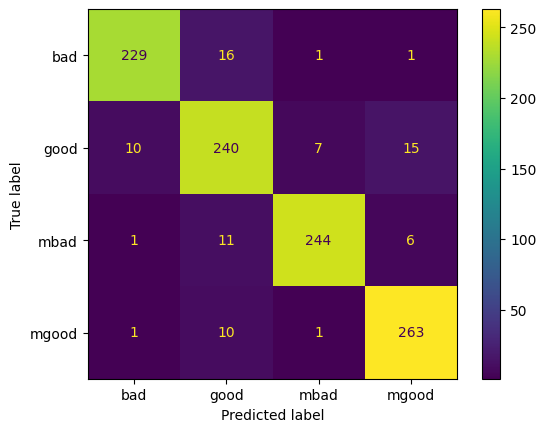

In [97]:
# load ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

# apply GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2'],
}

clf = GridSearchCV(ExtraTreesClassifier(), params, cv=5, n_jobs=-1, verbose=1)

# oversample and get train/test split
X, y = oversample.fit_resample(df_best_subset.drop(columns=["label"]), df_best_subset["label"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# print the best parameters
print("Best parameters:")
print(clf.best_params_)

# predict
y_pred = best_clf.predict(X_test)

# evaluate
from sklearn.metrics import accuracy_score

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))

# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()